In [2]:
#pip install torch

  Using cached torch-2.4.1-cp39-cp39-win_amd64.whl (199.3 MB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\dul3e\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
#pip install tensorflow==2.11.0


  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\dul3e\AppData\Local\Prog

In [4]:
#pip install neurite

  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19562 sha256=81f770fd0e73b2705c3ed4b229b6d9d093657c5b50bdb58fe44bb713403ed503
  Stored in directory: c:\users\dul3e\appdata\local\pip\cache\wheels\4c\0b\97\737411e14729d327252b31723354f9be51fc46fb364f4c02ea
Successfully built pystrum
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\dul3e\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as nnf
import neurite as ne

import matplotlib.pyplot as plt


TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [8]:
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'data.tar.gz'


# visualise data:

1.   using neurite
2.   using matplotlib



In [37]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]


train shape: (208, 192, 160)


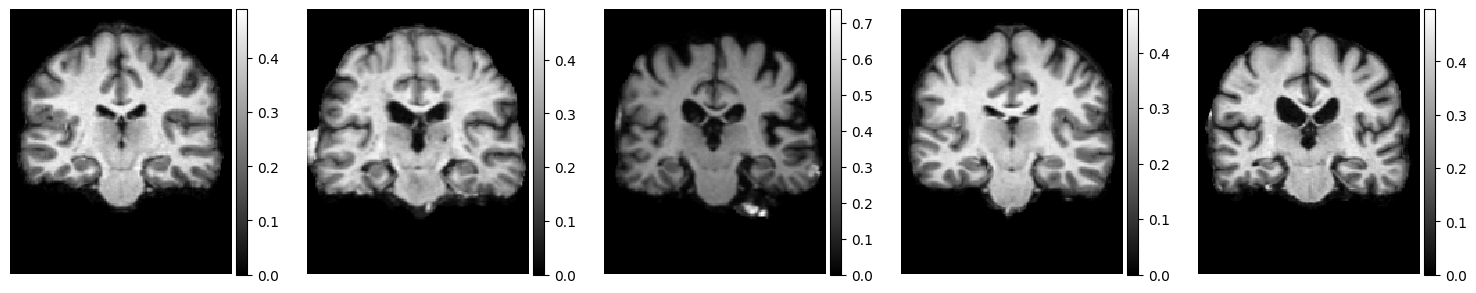

In [38]:
# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

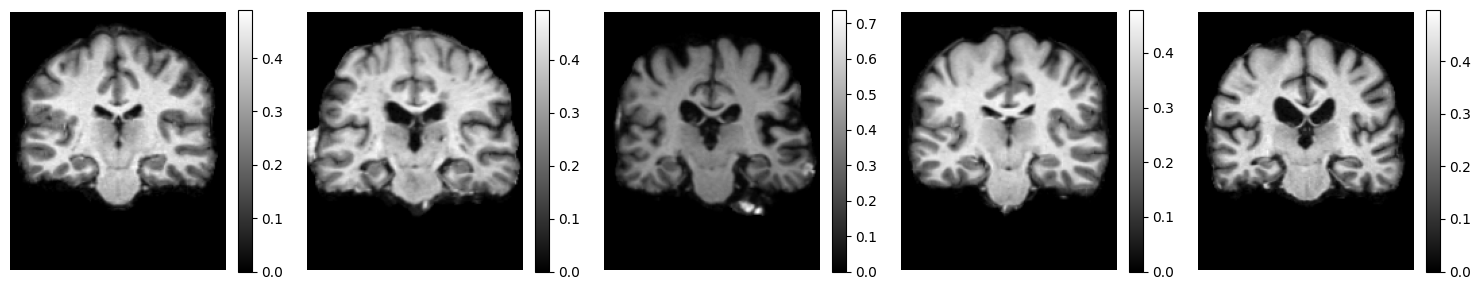

In [39]:
def plot_slices(data, cmap='gray', do_colorbars=False):

    num_samples = data.shape[0]

    # Create a single row with multiple columns
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # Ensure axes is a 1D array
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(data[i, :, :], cmap=cmap)
        ax.axis('off')
        if do_colorbars:
            plt.colorbar(ax.images[0], ax=ax, orientation='vertical')

    plt.tight_layout()
    plt.show()


# Visualize the extracted samples
plot_slices(x_train[idx, ...], cmap='gray', do_colorbars=True)


# d

In [45]:
from layers import *
import layers
import networks
import losses

In [42]:
import os
print(os.getcwd())


/content


In [44]:
# configure unet features
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]


# unet
vxm_model = networks.VxmDense(vol_shape, nb_features, int_steps=0)



NameError: name 'layers' is not defined

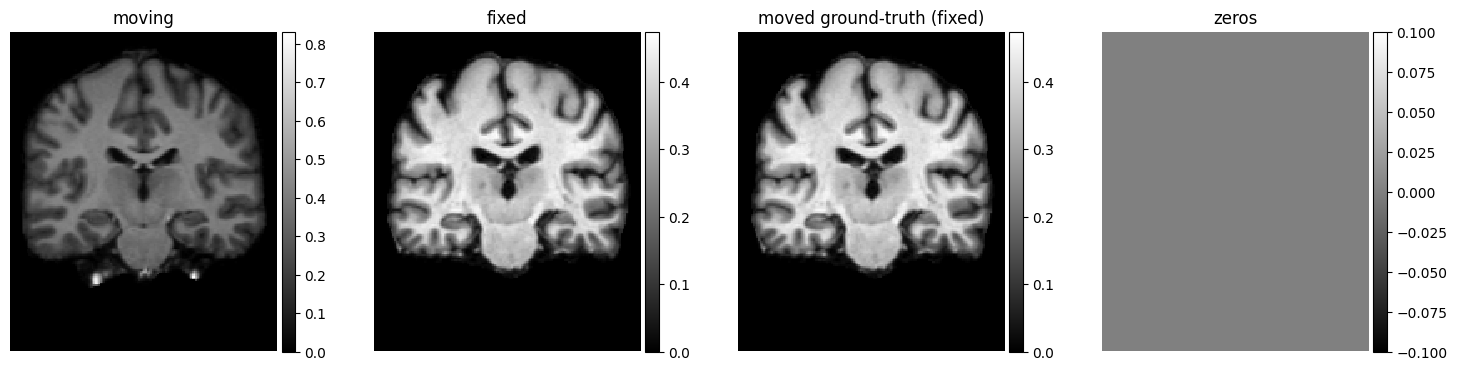

In [ ]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)


# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
from losses import *
import torch.optim as optim

# Instantiate your model


# Optimizer
optimizer = optim.Adam(vxm_model.parameters(), lr=1e-4)

# Instantiate the custom loss classes
ncc_loss = NCC()     # Normalized Cross-Correlation loss
mse_loss = MSE()     # Mean Squared Error loss
dice_loss = Dice()   # Dice loss
grad_loss = Grad()   # Gradient loss

# Define the loss weights (you can adjust these values)
loss_weights = [1, 0.01, 0.01, 0.05]
# Training loop
num_epochs = 10  # Number of epochs
batch_size = 32  # Size of each batch

for epoch in range(num_epochs):
    for _ in range(100):  # Assuming 100 iterations per epoch, adjust as needed
        # Get a batch of data
        in_sample, out_sample = next(train_generator)
        moving_images, fixed_images = in_sample
        target_data, _ = out_sample

        # Convert to PyTorch tensors
        moving_images = torch.tensor(moving_images, dtype=torch.float32)
        fixed_images = torch.tensor(fixed_images, dtype=torch.float32)
        target_data = torch.tensor(target_data, dtype=torch.float32)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass: Get model predictions
        y_source, _ = vxm_model(moving_images, fixed_images)

        # Calculate each loss component
        ncc = ncc_loss.loss(target_data, y_source)
        mse = mse_loss.loss(target_data, y_source)
        dice = dice_loss.loss(target_data, y_source)
        grad = grad_loss.loss(None, y_source)  # `None` for the true value because Grad only depends on the prediction

        # Combine losses with weights
        total_loss = (loss_weights[0] * ncc +
                      loss_weights[1] * mse +
                      loss_weights[2] * dice +
                      loss_weights[3] * grad)

        # Backpropagation
        total_loss.backward()

        # Update model parameters
        optimizer.step()

    # Print loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')

RuntimeError: Given groups=1, weight of size [32, 2, 3, 3, 3], expected input[1, 32, 384, 160, 1] to have 2 channels, but got 32 channels instead

In [ ]:
# Define your input shape and other parameters
inshape = (192, 192, 192)  # Example shape
vxm_model = networks.VxmDense(
    inshape=inshape,
    nb_unet_features=32,
    nb_unet_levels=3,
    unet_feat_mult=1,
    nb_unet_conv_per_level=1,
    int_steps=7,
    int_downsize=2,
    bidir=False,
    use_probs=False,
    src_feats=1,
    trg_feats=1,
    unet_half_res=False
)

# Define the loss functions and optimizer
ncc_loss = NCC()     # Normalized Cross-Correlation loss
mse_loss = MSE()     # Mean Squared Error loss
dice_loss = Dice()   # Dice loss
grad_loss = Grad()   # Gradient loss

# Define the loss weights
loss_weights = [1, 0.01, 0.01, 0.05]
optimizer = optim.Adam(vxm_model.parameters(), lr=1e-4)


In [ ]:
num_epochs = 10  # Number of epochs

for epoch in range(num_epochs):
    for batch_data, target_data in dataloader:
        moving_images, fixed_images = batch_data
        _, zero_phi = target_data  # zero_phi is not used directly but required for gradient loss

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass: Get model predictions
        y_source, pos_flow = vxm_model(moving_images, fixed_images)

        # Calculate each loss component
        ncc = ncc_loss.loss(fixed_images, y_source)
        mse = mse_loss.loss(fixed_images, y_source)
        dice = dice_loss.loss(fixed_images, y_source)
        grad = grad_loss.loss(zero_phi, pos_flow)  # Use zero_phi for gradient loss

        # Combine losses with weights
        total_loss = (loss_weights[0] * ncc +
                      loss_weights[1] * mse +
                      loss_weights[2] * dice +
                      loss_weights[3] * grad)

        # Backpropagation
        total_loss.backward()

        # Update model parameters
        optimizer.step()

    # Print loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')


RuntimeError: Given groups=1, weight of size [32, 2, 3, 3, 3], expected input[1, 32, 384, 160, 1] to have 2 channels, but got 32 channels instead